In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn import preprocessing, svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
nltk.download('stopwords')


C:\Users\jmitc\AppData\Local\Temp\ipykernel_11960\3247464202.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmitc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing, Data Organization and Visualization

In [2]:
df = pd.read_csv("DisneylandReviews.csv", encoding='latin-1')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


* Reading the csv and utilizing encoding "latin-1" due to UTF8 error

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


* Checking the ratings in the DisneyLand csv 5 being data that is most positive, 3 being the median rating and 1 being the lowest rating 

Text(0.5, 1.0, 'Branch Distribution')

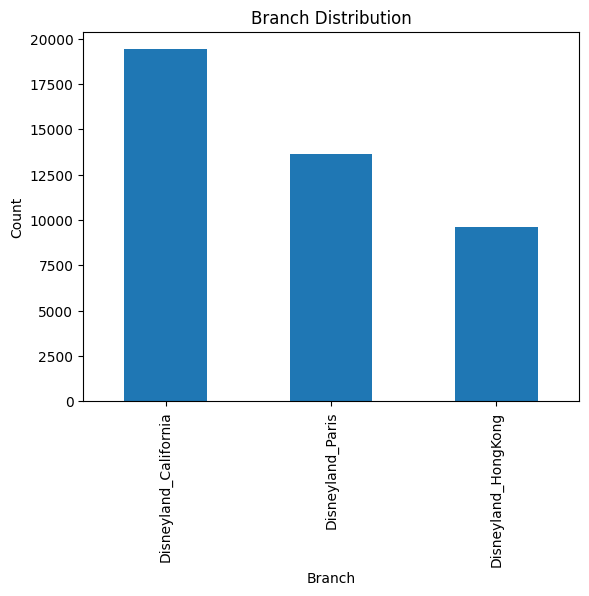

In [4]:
branches = df.groupby('Branch').size().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Branch')
plt.ylabel('Count')
plt.title('Branch Distribution')

Text(0.5, 1.0, 'Branch Rating Distribution')

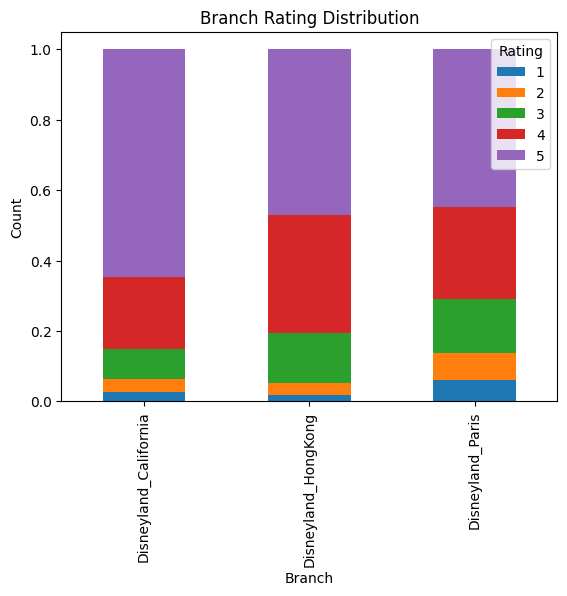

In [5]:
branchrate = pd.crosstab(df.Branch, df.Rating)
branchrate.div(branchrate.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('Branch')
plt.ylabel('Count')
plt.title('Branch Rating Distribution')


Text(0.5, 1.0, 'Branch Rating')

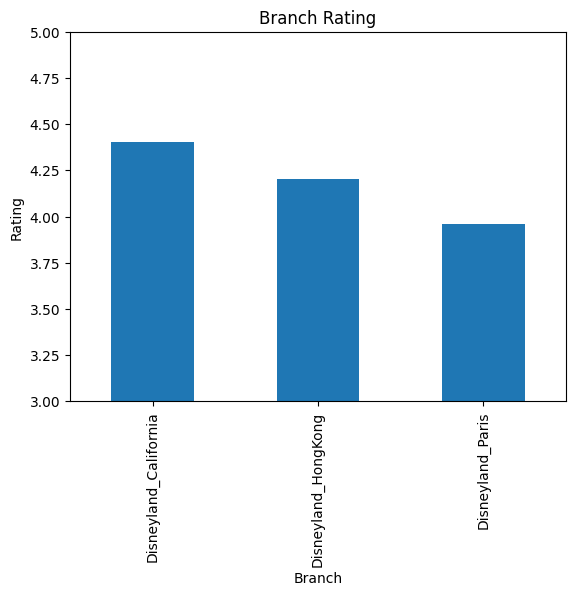

In [6]:
fig, ax = plt.subplots()
branchData = df.groupby('Branch')['Rating'].mean().sort_values(ascending=False).plot(kind='bar')
ax.set_ylim(3, 5)
plt.xlabel('Branch')
plt.ylabel('Rating')
plt.title('Branch Rating')


<Axes: ylabel='Frequency'>

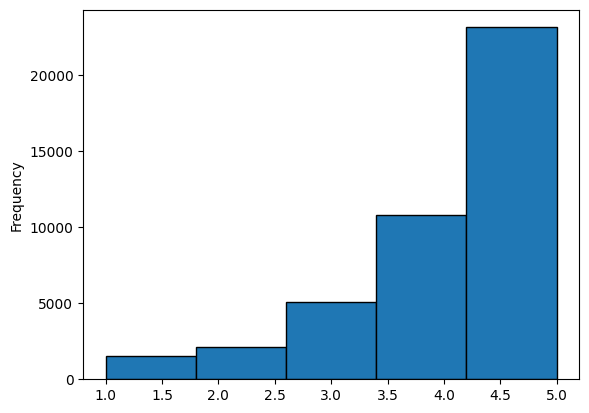

In [7]:
df.Rating.plot(kind='hist', bins=5, edgecolor='black')

Text(0.5, 1.0, 'Rating Distribution')

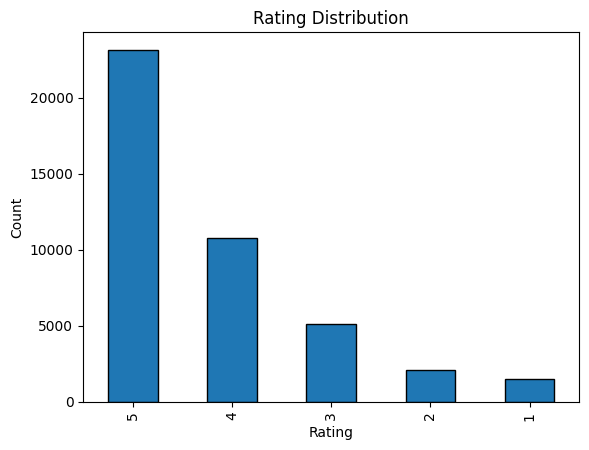

In [8]:
df.Rating.value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')

Sentiment Analysis

In [9]:
positive = df[df['Rating'] > 3]
negative = df[df['Rating'] < 3]
indifferent = df[df['Rating'] == 3]
total = len(positive) + len(negative) + len(indifferent)
positive.shape, negative.shape, indifferent.shape, total

((33921, 6), (3626, 6), (5109, 6), 42656)

In [10]:
df.Rating.value_counts()

Rating
5    23146
4    10775
3     5109
2     2127
1     1499
Name: count, dtype: int64

In [11]:
df.Rating.info()

<class 'pandas.core.series.Series'>
RangeIndex: 42656 entries, 0 to 42655
Series name: Rating
Non-Null Count  Dtype
--------------  -----
42656 non-null  int64
dtypes: int64(1)
memory usage: 333.4 KB


In [12]:
df = df[df.Rating != 3]
df['Sentiment'] = df.Rating.apply(lambda rating: 1 if rating > 3 else 0)
df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,1
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,1
10,670443403,5,2019-4,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,1
11,670435886,5,2019-4,Canada,We spent the day here with our grown kids and ...,Disneyland_HongKong,1


In [13]:
df.Sentiment.value_counts()

Sentiment
1    33921
0     3626
Name: count, dtype: int64

In [14]:
positive = df[df.Sentiment == 1]
negative = df[df.Sentiment == 0]

<Axes: title={'center': '[P/N] Sentiment Distribution'}, xlabel='Positive & Negative', ylabel='Count'>

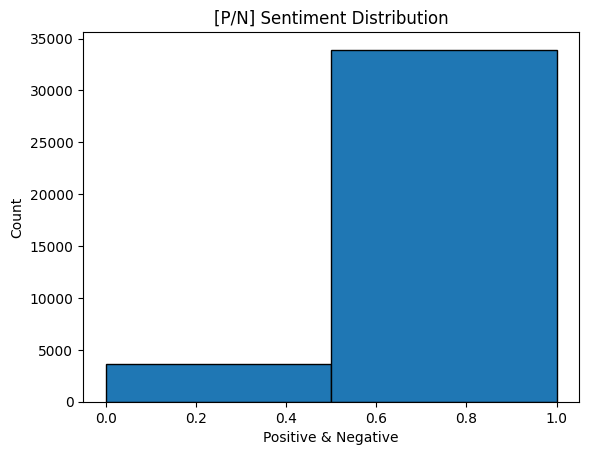

In [15]:
df['Sentimentt'] = df.Sentiment.replace({1: 'positive', 0: 'negative'})
df['Sentiment'].plot(kind='hist', bins=2, edgecolor='black', xlabel='Positive & Negative', ylabel='Count', title='[P/N] Sentiment Distribution')

<Axes: title={'center': 'Branch Sentiment Distribution'}, xlabel='Branch', ylabel='Count'>

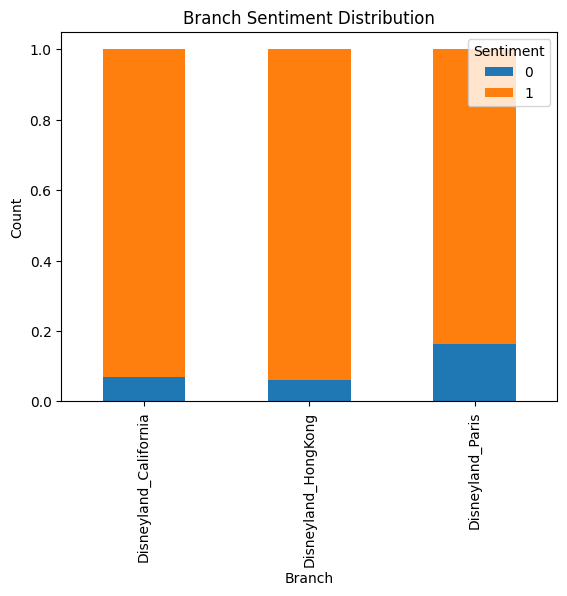

In [16]:
sentimentval = pd.crosstab(df.Branch, df.Sentiment)
sentimentval.div(sentimentval.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, xlabel='Branch', ylabel='Count', title='Branch Sentiment Distribution')

In [17]:
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['Review_clean_Text'] = df['Review_Text'].apply(remove_punctuation)
df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment,Sentimentt,Review_clean_Text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1,positive,If youve ever been to Disneyland anywhere youl...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,positive,Its been a while since d last time we visit HK...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1,positive,Thanks God it wasn t too hot or too humid wh...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1,positive,HK Disneyland is a great compact park Unfortun...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1,positive,the location is not in the city took around 1 ...
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,1,positive,Great place Your day will go by and you wont e...
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0,negative,Feel so let down with this placethe Disneyland...
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,1,positive,I can go on talking about Disneyland Whatever ...
10,670443403,5,2019-4,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,1,positive,Disneyland never cease to amaze me Ive been to...
11,670435886,5,2019-4,Canada,We spent the day here with our grown kids and ...,Disneyland_HongKong,1,positive,We spent the day here with our grown kids and ...


* Removal of punctuations, Data cleaning and adding to a new df column.


In [18]:
X = df['Review_clean_Text']
y = df['Sentiment']

In [19]:
def text_fit(X, y, nlp_model, ml_model, coef_show=1):
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml = ml_model.fit(X_train, y_train)
    ypred = ml.predict(X_test)
    recall = recall_score(y_test, ypred)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy_score(y_test, ypred))
    if coef_show == 1:
        w = nlp_model.get_feature_names_out()
        conf_matrix = confusion_matrix(y_test, ypred)
        print("Confusion Matrix: ", conf_matrix)
        ml.fit(X_train, y_train)
        coef = ml.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word': w, 'Coefficient': coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coeff_df.tail(20).to_string(index=False))
    
    return recall
    

In [20]:
tfidf_n = TfidfVectorizer(stop_words='english', max_df=0.7)
lr = LogisticRegression()
text_fit(X, y, tfidf_n, lr, coef_show=1)

features: 66812
 train records: 28160
 test records: 9387
Recall:  0.9933075026417753
Accuracy:  0.9454564823692341
Confusion Matrix:  [[ 415  455]
 [  57 8460]]

-Top 20 positive-
     Word  Coefficient
    great     7.516331
    loved     5.792304
  amazing     5.780797
      fun     4.470356
fantastic     4.361426
     love     4.204969
wonderful     3.901626
  enjoyed     3.871196
     best     3.790427
  awesome     3.340096
  magical     3.246766
      bit     3.245538
     time     3.242611
    clean     3.161517
   plenty     3.139850
     lots     3.103246
     good     2.846342
excellent     2.811593
     days     2.686043
  perfect     2.651615

-Top 20 negative-
          Word  Coefficient
         staff    -3.140797
        people    -3.180811
    ridiculous    -3.186366
        broken    -3.215849
           rip    -3.307327
         worse    -3.338002
          hour    -3.451282
    overpriced    -3.493276
disappointment    -3.592298
        closed    -3.680809
         

0.9933075026417753

In [21]:
def display_review_sentiment(i):
    print(df['Review_Text'][i])
    print('Actual sentiment: ', df['Sentimentt'][i])
    print('Predicted sentiment: ', df['Sentimentt'][i])
    print('Predicted probability [Negative, Positive]: ', lr.predict_proba(tfidf_n.transform([df['Review_clean_Text'][i]])))

In [22]:
display_review_sentiment(0)

If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides  its a Small World  is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well. 
Actual sentiment:  positive
Predicted sentiment:  positive
Predicted probability [Negative, Positive]:  [[0.01230041 0.98769959]]


In [23]:
def getReviewsSentiment(rating, review_clean_text):
    if rating <3:
        return 0
    else:
        #combine rating and review text
        text = str(rating) + " " + review_clean_text
        #predict sentiment
        sentiment = lr.predict(tfidf_n.transform([text]))
        if sentiment > 0:
            return 1
        else:
            return 0        

In [24]:
df['Sentiment'] = df.apply(lambda x: getReviewsSentiment(x['Rating'], x['Review_clean_Text']), axis=1)
df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment,Sentimentt,Review_clean_Text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1,positive,If youve ever been to Disneyland anywhere youl...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,positive,Its been a while since d last time we visit HK...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1,positive,Thanks God it wasn t too hot or too humid wh...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1,positive,HK Disneyland is a great compact park Unfortun...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1,positive,the location is not in the city took around 1 ...
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,1,positive,Great place Your day will go by and you wont e...
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0,negative,Feel so let down with this placethe Disneyland...
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,1,positive,I can go on talking about Disneyland Whatever ...
10,670443403,5,2019-4,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,1,positive,Disneyland never cease to amaze me Ive been to...
11,670435886,5,2019-4,Canada,We spent the day here with our grown kids and ...,Disneyland_HongKong,1,positive,We spent the day here with our grown kids and ...


In [25]:
#clean the data to improve accuracy, make it lower case, remove punctuation, remove stop words, and stem the words
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.lower()
    return text

In [26]:
df['Review_clean_Text'] = df['Review_Text'].apply(clean_text)
df.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment,Sentimentt,Review_clean_Text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1,positive,if you've ever been to disneyland anywhere you...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,positive,its been a while since d last time we visit hk...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1,positive,thanks god it wasn t too hot or too humid wh...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1,positive,hk disneyland is a great compact park unfortu...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1,positive,the location is not in the city took around ...


## Data Cleaning 

* The function's purpose is to prepare text data for machine learning models by making it more uniform and less noisy. This preprocessing can significantly improve the performance of models by ensuring that the input data is in a consistent format that the models can learn from effectively.


In [27]:
def removeStopWords(text):
    stop = set(stopwords.words('english'))
    words = text.split()
    filter = [word for word in words if word.lower() not in stop]
    return ' '.join(filter)

In [28]:
df['Review_clean_Text'] = df['Review_clean_Text'].apply(removeStopWords)
df.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment,Sentimentt,Review_clean_Text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1,positive,ever disneyland anywhere find disneyland hong ...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,positive,since last time visit hk disneyland yet time s...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1,positive,thanks god hot humid visiting park otherwise w...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1,positive,hk disneyland great compact park unfortunately...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1,positive,location city took around hour kowlon kids lik...


In [29]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
lr = LogisticRegression()
text_fit(X, y, tfidf_n, lr, coef_show=1)

features: 938331
 train records: 28160
 test records: 9387
Recall:  0.9990607021251614
Accuracy:  0.9278789815702567
Confusion Matrix:  [[ 201  669]
 [   8 8509]]

-Top 20 positive-
      Word  Coefficient
     great     7.968457
     loved     5.682087
   amazing     5.660738
       fun     5.061430
      love     4.438208
      best     3.874022
   enjoyed     3.816397
 fantastic     3.800283
      time     3.641724
 wonderful     3.392427
 fireworks     3.128538
   magical     3.126008
      lots     2.984800
   awesome     2.982514
     clean     2.973223
       bit     2.925754
      good     2.925745
great time     2.695232
    plenty     2.674560
    parade     2.626196

-Top 20 negative-
          Word  Coefficient
         broke    -3.229607
         paris    -3.264661
disappointment    -3.393931
           pay    -3.501363
         dirty    -3.524236
          paid    -3.533656
    overpriced    -3.660347
 disappointing    -4.334156
         staff    -4.426629
         worst 

0.9990607021251614

# Text Classification


In [30]:
#textfit that checkes for f1 score
def text_fit2(X, y,model, ml_model, coef_show=1):
    c = model.fit_transform(X)
    print('features: {}'.format(c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(c, y, random_state=0)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml = ml_model.fit(X_train, y_train)
    ypred = ml.predict(X_test)
    f1 = f1_score(y_test, ypred)
    print('F1: ', f1)
    if coef_show == 1:
        names = model.get_feature_names_out()
        coef = ml.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Word': names, 'Coefficient': coef})
        coef_df = coef_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coef_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coef_df.tail(20).to_string(index=False))
    return f1

In [31]:
X = df['Review_clean_Text']
y = df['Sentiment']
lr = LogisticRegression()
tfidf_n2 = TfidfVectorizer(stop_words='english')

In [32]:
#(b) Logistic regression with TfidfVectorizer
f1_score_text = text_fit2(X, y, tfidf_n2, lr)

features: 36290
 train records: 28160
 test records: 9387
F1:  0.9748035136384651

-Top 20 positive-
     Word  Coefficient
    great     7.665973
  amazing     5.673024
    loved     5.622442
      fun     4.510116
fantastic     4.463151
     love     4.039593
wonderful     3.928459
  enjoyed     3.866223
     best     3.848006
     time     3.345864
  awesome     3.302763
      bit     3.286234
  magical     3.164324
    clean     3.133758
   plenty     3.110939
     lots     3.081731
     good     2.873319
excellent     2.800192
   lovely     2.732996
  perfect     2.682320

-Top 20 negative-
          Word  Coefficient
           rip    -3.494974
        broken    -3.517565
         broke    -3.525610
         worse    -3.617998
    ridiculous    -3.694835
        people    -3.707730
          hour    -3.734178
          paid    -3.762554
disappointment    -3.840130
         dirty    -4.087404
  disappointed    -4.207958
         hours    -4.340420
        closed    -4.368727
 disa

In [33]:
#(a)logistic regression on word count
cv = CountVectorizer()
lr = LogisticRegression()
f2_score_text = text_fit2(X, y, cv, lr, coef_show=1)

features: 36557
 train records: 28160
 test records: 9387
F1:  0.976910454758556

-Top 20 positive-
     Word  Coefficient
fantastic     2.255632
  longest     2.117611
    blast     2.035875
  amazing     1.746815
wonderful     1.734214
  perfect     1.729525
    loved     1.729264
   lovely     1.669246
 downside     1.662514
  awesome     1.531848
advantage     1.520915
    great     1.356620
    liked     1.352686
 fabulous     1.308456
      fab     1.274190
brilliant     1.201906
excellent     1.195891
  enjoyed     1.146671
 separate     1.144591
    bonus     1.136538

-Top 20 negative-
          Word  Coefficient
        boring    -1.477179
         roped    -1.615432
         broke    -1.628231
         dated    -1.664724
       mistake    -1.698592
           sad    -1.705781
    ridiculous    -1.760656
         worse    -1.765753
      horrible    -1.769315
     miserable    -1.802958
disappointment    -1.818673
          date    -1.839365
 disappointing    -1.845895
   ove

In [34]:
#(c)logistic regression with TfidfVectorizer and ngram
tfidf_n3 = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
f3_score_text = text_fit2(X, y, tfidf_n3, lr, coef_show=1)

features: 817667
 train records: 28160
 test records: 9387
F1:  0.9630515229148876

-Top 20 positive-
      Word  Coefficient
     great     8.032016
   amazing     5.696278
     loved     5.686742
       fun     5.091934
      love     4.373736
      best     4.001763
 fantastic     3.885992
   enjoyed     3.873077
      time     3.692760
 wonderful     3.444656
   magical     3.142839
 fireworks     3.129349
     clean     3.028967
      lots     3.017698
   awesome     2.994021
       bit     2.979866
      good     2.888810
    plenty     2.731746
great time     2.722997
     early     2.645854

-Top 20 negative-
          Word  Coefficient
         paris    -3.613934
           pay    -3.637474
    overpriced    -3.652061
       minutes    -3.682983
         dirty    -3.723079
disappointment    -3.732680
          paid    -4.062687
 disappointing    -4.379491
         worst    -4.605819
          hour    -4.796937
         staff    -4.840945
         waste    -5.087665
  disappoin

In [35]:
#(d) svm model on word count
f4_score_text = text_fit2(X, y, cv, svm.LinearSVC(), coef_show=1)

features: 36557
 train records: 28160
 test records: 9387


c:\Users\jmitc\anaconda3\envs\Assignment\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1:  0.9725721012360212

-Top 20 positive-
      Word  Coefficient
   longest     1.116943
 fantastic     1.091826
     blast     1.024261
 advantage     0.911939
   causing     0.878955
  downside     0.871292
       fab     0.848501
   perfect     0.821647
   aspects     0.814816
 wonderful     0.814223
  downfall     0.808346
resturants     0.804167
     doubt     0.790479
     bonus     0.785127
    saving     0.778591
rediculous     0.769516
     silly     0.753791
     asian     0.739835
 obscenely     0.736468
    theres     0.730188

-Top 20 negative-
          Word  Coefficient
        crappy    -0.926445
         cable    -0.928273
          poor    -0.941771
       mistake    -0.960648
       cleaned    -0.978900
        sucked    -0.996518
         canes    -1.017032
     decreased    -1.025898
     miserable    -1.028062
           rip    -1.048269
     prebooked    -1.080312
dissapointment    -1.093542
       equates    -1.144503
            uo    -1.151931
         greed

In [36]:
# (e) svm model on TfidfVectorizer
f5_score_text = text_fit2(X, y, tfidf_n2, svm.LinearSVC(), coef_show=1)

features: 36290
 train records: 28160
 test records: 9387


c:\Users\jmitc\anaconda3\envs\Assignment\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1:  0.9777336216468938

-Top 20 positive-
     Word  Coefficient
    great     3.648141
fantastic     3.327532
  amazing     3.185859
    loved     2.733857
wonderful     2.495036
  longest     2.364240
    blast     2.158468
   lovely     2.107989
   plenty     1.955663
      fun     1.950999
      bit     1.948445
 downside     1.933542
  awesome     1.917285
  perfect     1.899123
     best     1.776055
advantage     1.773763
excellent     1.727217
     love     1.700508
  noticed     1.662597
     lots     1.620259

-Top 20 negative-
          Word  Coefficient
         hours    -1.930355
      horrible    -1.944851
          paid    -1.982810
           sad    -2.007565
    ridiculous    -2.031233
          thou    -2.067158
         dated    -2.097816
   overcrowded    -2.102815
         broke    -2.124744
disappointment    -2.135846
 disappointing    -2.161291
         worse    -2.161690
           rip    -2.288057
          told    -2.339225
         worst    -2.478053
       

In [37]:
# (f) svm model on TfidfVectorizer and ngram
f6_score_text = text_fit2(X, y, tfidf_n3, svm.LinearSVC(), coef_show=1)

features: 817667
 train records: 28160
 test records: 9387


c:\Users\jmitc\anaconda3\envs\Assignment\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1:  0.9772319100863218

-Top 20 positive-
     Word  Coefficient
    great     3.583743
  amazing     3.025483
    loved     2.896268
fantastic     2.530431
      fun     2.244640
     best     2.093176
     love     2.069270
      bit     2.040084
wonderful     2.032481
  enjoyed     1.839724
   plenty     1.757136
     time     1.750391
  awesome     1.714443
  magical     1.714371
excellent     1.635048
     lots     1.600753
  longest     1.590928
   lovely     1.587880
    clean     1.583381
     good     1.543802

-Top 20 negative-
          Word  Coefficient
   overcrowded    -2.081792
          hour    -2.125875
         broke    -2.154175
        broken    -2.204473
        closed    -2.353026
          paid    -2.400848
           rip    -2.424091
disappointment    -2.428577
         worse    -2.465568
    ridiculous    -2.482062
         hours    -2.532354
  disappointed    -2.603465
 disappointing    -2.652113
         dirty    -2.745805
          told    -2.896981
       

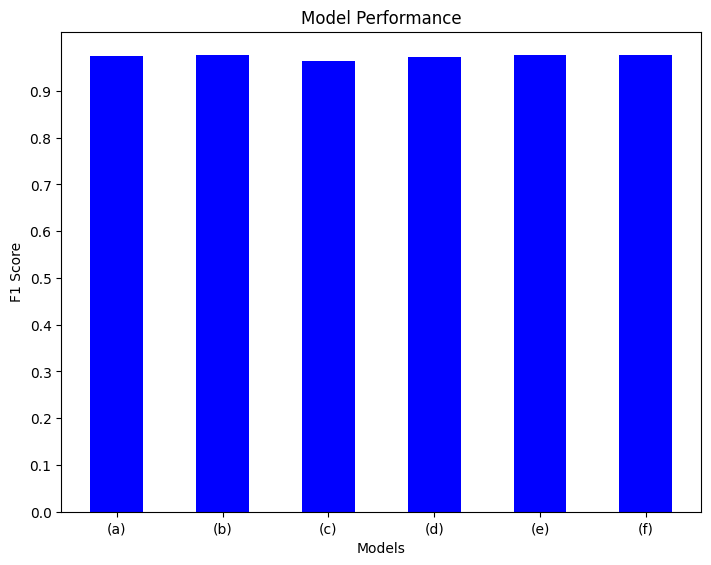

In [38]:
#bargraph  showing performance on each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
scores = [f1_score_text, f2_score_text, f3_score_text, f4_score_text, f5_score_text, f6_score_text]
ax.bar(models, scores, color = 'blue', width = 0.5)
ax.set_yticks(np.arange(0, 1, 0.1))
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Model Performance')
plt.show()


Topic Modeling

In [39]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index], "\n")

In [40]:
X = df['Review_clean_Text']
document = list(X)[0:100000]

#NMF is able to use tf-idf
tfidf_n = TfidfVectorizer(max_df=0.90, min_df= 2,stop_words='english')
tfid = tfidf_n.fit_transform(document)
feature_names = tfidf_n.get_feature_names_out()

* The number of topics chosen for the analysis is 10. This number was chosen based on the assumption that it would provide a comprehensive view of the main themes or categories that the algorithms would identify in the text data. The topics are derived from the top 10 words that each algorithm chooses for each topic cluster

In [41]:
#Usin TFIDF and count vectorizer to perform NMF
no_topics = 10
no_top_words = 10
no_top_documents = 5

nmf = NMF(n_components=no_topics, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfid)
nmftopic = nmf.transform(tfid)
nmfTop = nmf.components_

#display topics
print("NMF Topics with TFIDF \n")
display_topics(nmfTop, nmftopic, feature_names, document, no_top_words, no_top_documents)


c:\Users\jmitc\anaconda3\envs\Assignment\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Topics with TFIDF 

Topic 0:
food good park rides queues children expensive queue staff really
first france america reason staff may rude ignorant rude english visitors saw many people yapping english even say thank french learn basic stuff like please thank hello get long way believe made mistakes encounter single rude member staff actually many smiled even helpful tried worried negative reviews easily impressed went quite low expectations daughters th birthday want good wow impressed whole experience yes minor gripes apart planning preparation key good experience though booked whole package via disney website two adults year old got air flights coach shuttles hotel two nights b b disney hotel newport bay see separate review three days unlimited entry disneyland park studios lot money seemed good way pre booked shuttle hotel orderly took minutes door hotel return friday rush hour traffic still minutes would cost one way paid day park look run see people saying thing think discover

In [42]:
# LDA
tf_vect = CountVectorizer(max_df=0.90, min_df= 2,stop_words='english')
tf = tf_vect.fit_transform(document)
feature_names = tf_vect.get_feature_names_out()

In [43]:
#Usin TFIDF and count vectorizer to perform LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_topic = lda.transform(tf)
ldaTop = lda.components_

#display topics
print("LDA Topics with Count Vectorizer \n")
display_topics(ldaTop, lda_topic, feature_names, document, no_top_words, no_top_documents)

LDA Topics with Count Vectorizer 

Topic 0:
disney park disneyland rides time great day visit parks kids
three us went trip fortunate go disneyworld two years ago park california adventure park appears disney tried highlight major rides attractions four parks disneyworld california adventure park cap park clean rides still long waits disneyland california adventure park saw two characters adventure park none disneyland older kids rides better adventure park workers locals disneyworld disneyworld feels truly like magical place disneyland cap feel like expensive admusement parks long story short afford go florida go magical place can't know missing want compare two go california first watch magic happen florida 

personally gone disneyland outside california didnt know expect cultural ties chinese culture implemented park simply amazing probably park mickey speak cantonese park clean smaller typical disney park various shows watch throughout park rides similar would find california belie

In [44]:
#SVD
lsi = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_topic = lsi.transform(tf)
lsiTop = lsi.components_

#display topics
print("LSI Topics with Count Vectorizer \n")
display_topics(lsiTop, lsi_topic, feature_names, document, no_top_words, no_top_documents)

LSI Topics with Count Vectorizer 

Topic 0:
park disney rides disneyland time day ride great food kids
doug disney trip july july family went disneyland july tall overweight could find much information would affect experience disney decided write experience let say weigh pounds depression moment lose pounds considered obese weight chart currently waist best talk experiences fat man disney well offer tips tricks get trip little background information planner analyze plan execute several backup plans available case purchased day non hopper pass intent spending one day disneyland one day california adventures wanted day park hopper wife convinced days enough wanted day park hopper park admission day goes purchase days purchase day pass cost couple bucks day buying day hopper pass also lets get one magic morning allows enter one park one hour general public enter park days magic morning explain worked family arrived anaheim sunday night family year old high functioning autism checked anahe

* Topic 0: This topic is about the overall experience of visiting Disneyland, including the food, rides, queues, and staff behavior. The words chosen for this topic cluster reflect the various aspects of the experience.

* Topic 1: This topic is about the sentiment or emotion expressed in the reviews, specifically the happiness and excitement of the visitors. The words chosen for this topic cluster reflect the positive emotions and sentiments expressed in the reviews.

* Topic 2: This topic is about the comparison between different Disney parks, including Disneyland, Disney World, and Disneyland Paris. The words chosen for this topic cluster reflect the various aspects of the comparison.

* Topic 3: This topic is about the use of fast passes and the impact of long lines on the overall experience. The words chosen for this topic cluster reflect the various aspects of this aspect of the experience.

* Topic 4: This topic is about the fun and enjoyment derived from the rides, shows, and food at Disneyland. The words chosen for this topic cluster reflect the various aspects of the fun and enjoyment.

* Topic 5: This topic is about the comparison between Disneyland and Hong Kong Disneyland. The words chosen for this topic cluster reflect the various aspects of the comparison.

* Topic 6: This topic is about the favorite rides at Disneyland. The words chosen for this topic cluster reflect the various rides that visitors enjoy.

* Topic 7: This topic is about the love for Disneyland and the best time to visit. The words chosen for this topic cluster reflect the various sentiments and preferences expressed in the reviews.

* Topic 8: This topic is about the day pass and the use of fast passes. The words chosen for this topic cluster reflect the various aspects of the day pass and the use of fast passes.

* Topic 9: This topic is about the staff at Disneyland and their behavior. The words chosen for this topic cluster reflect the various aspects of the staff's behavior.

* Each topic falls under the category of "Disneyland Experience" as they all relate to the experience of visiting Disneyland. The words chosen for each topic cluster reflect the various aspects of this experience, including the food, rides, queues, staff behavior, sentiment or emotion, comparison between different Disney parks, use of fast passes, fun and enjoyment derived from the rides, shows, and food, comparison between Disneyland and Hong Kong Disneyland, favorite rides, love for Disneyland, and the staff's behavior.